Data Source:

De Cock, D. (2011). Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project. Journal of Statistics Education, 19(3). https://doi.org/10.1080/10691898.2011.11889627

In [2]:
import pandas as pd
import numpy as np
import sys
import pickle
import importlib

In this tutorial, we use Pyreal's decision tree explainer to help explain the AmesHousing dataset.

Sections of data-loading and transformers are the same as the `lfc` tutorial.

In [3]:
data = pd.read_csv("data.csv")
data = data[data.GrLivArea < 4000]
y_orig = data["SalePrice"]
x_orig = data.drop("SalePrice", axis="columns")
print(x_orig.shape, y_orig.shape)

(1456, 80) (1456,)


Next, we load in the interpretable feature descriptions.

In [4]:
descriptions_df = pd.read_csv("feature_descriptions.csv")
descriptions = descriptions_df.set_index("Name").to_dict()["Description"]

Next, we prepare the transfomers.

The first kind of transformer manually imputes the data based on information we know about the dataset.
We will call this the `AmesHousingImputer`

This imputation code comes from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

In [5]:
from pyreal.transformers import Transformer

class AmesHousingImputer(Transformer):
    def data_transform(self, x):
            x_transform = x.copy()
            # Alley : data description says NA means "no alley access"
            x_transform.loc[:, "Alley"] = x_transform.loc[:, "Alley"].fillna("None")
            # BedroomAbvGr : NA most likely means 0
            x_transform.loc[:, "BedroomAbvGr"] = x_transform.loc[:, "BedroomAbvGr"].fillna(0)
            # BsmtQual etc : x_transform description says NA for basement features is "no basement"
            x_transform.loc[:, "BsmtQual"] = x_transform.loc[:, "BsmtQual"].fillna("No")
            x_transform.loc[:, "BsmtCond"] = x_transform.loc[:, "BsmtCond"].fillna("No")
            x_transform.loc[:, "BsmtExposure"] = x_transform.loc[:, "BsmtExposure"].fillna("No")
            x_transform.loc[:, "BsmtFinType1"] = x_transform.loc[:, "BsmtFinType1"].fillna("No")
            x_transform.loc[:, "BsmtFinType2"] = x_transform.loc[:, "BsmtFinType2"].fillna("No")
            x_transform.loc[:, "BsmtFullBath"] = x_transform.loc[:, "BsmtFullBath"].fillna(0)
            x_transform.loc[:, "BsmtHalfBath"] = x_transform.loc[:, "BsmtHalfBath"].fillna(0)
            x_transform.loc[:, "BsmtUnfSF"] = x_transform.loc[:, "BsmtUnfSF"].fillna(0)
            # CentralAir : NA most likely means No
            x_transform.loc[:, "CentralAir"] = x_transform.loc[:, "CentralAir"].fillna("N")
            # Condition : NA most likely means Normal
            x_transform.loc[:, "Condition1"] = x_transform.loc[:, "Condition1"].fillna("Norm")
            x_transform.loc[:, "Condition2"] = x_transform.loc[:, "Condition2"].fillna("Norm")
            # EnclosedPorch : NA most likely means no enclosed porch
            x_transform.loc[:, "EnclosedPorch"] = x_transform.loc[:, "EnclosedPorch"].fillna(0)
            # External stuff : NA most likely means average
            x_transform.loc[:, "ExterCond"] = x_transform.loc[:, "ExterCond"].fillna("TA")
            x_transform.loc[:, "ExterQual"] = x_transform.loc[:, "ExterQual"].fillna("TA")
            # Fence : x_transform description says NA means "no fence"
            x_transform.loc[:, "Fence"] = x_transform.loc[:, "Fence"].fillna("No")
            # FireplaceQu : x_transform description says NA means "no fireplace"
            x_transform.loc[:, "FireplaceQu"] = x_transform.loc[:, "FireplaceQu"].fillna("No")
            x_transform.loc[:, "Fireplaces"] = x_transform.loc[:, "Fireplaces"].fillna(0)
            # Functional : x_transform description says NA means typical
            x_transform.loc[:, "Functional"] = x_transform.loc[:, "Functional"].fillna("Typ")
            # GarageType etc : x_transform description says NA for garage features is "no garage"
            x_transform.loc[:, "GarageType"] = x_transform.loc[:, "GarageType"].fillna("No")
            x_transform.loc[:, "GarageFinish"] = x_transform.loc[:, "GarageFinish"].fillna("No")
            x_transform.loc[:, "GarageQual"] = x_transform.loc[:, "GarageQual"].fillna("No")
            x_transform.loc[:, "GarageCond"] = x_transform.loc[:, "GarageCond"].fillna("No")
            x_transform.loc[:, "GarageArea"] = x_transform.loc[:, "GarageArea"].fillna(0)
            x_transform.loc[:, "GarageCars"] = x_transform.loc[:, "GarageCars"].fillna(0)
            # HalfBath : NA most likely means no half baths above grade
            x_transform.loc[:, "HalfBath"] = x_transform.loc[:, "HalfBath"].fillna(0)
            # HeatingQC : NA most likely means typical
            x_transform.loc[:, "HeatingQC"] = x_transform.loc[:, "HeatingQC"].fillna("TA")
            # KitchenAbvGr : NA most likely means 0
            x_transform.loc[:, "KitchenAbvGr"] = x_transform.loc[:, "KitchenAbvGr"].fillna(0)
            # KitchenQual : NA most likely means typical
            x_transform.loc[:, "KitchenQual"] = x_transform.loc[:, "KitchenQual"].fillna("TA")
            # LotFrontage : NA most likely means no lot frontage
            x_transform.loc[:, "LotFrontage"] = x_transform.loc[:, "LotFrontage"].fillna(0)
            # LotShape : NA most likely means regular
            x_transform.loc[:, "LotShape"] = x_transform.loc[:, "LotShape"].fillna("Reg")
            # MasVnrType : NA most likely means no veneer
            x_transform.loc[:, "MasVnrType"] = x_transform.loc[:, "MasVnrType"].fillna("None")
            x_transform.loc[:, "MasVnrArea"] = x_transform.loc[:, "MasVnrArea"].fillna(0)
            # MiscFeature : x_transform description says NA means "no misc feature"
            x_transform.loc[:, "MiscFeature"] = x_transform.loc[:, "MiscFeature"].fillna("No")
            x_transform.loc[:, "MiscVal"] = x_transform.loc[:, "MiscVal"].fillna(0)
            # OpenPorchSF : NA most likely means no open porch
            x_transform.loc[:, "OpenPorchSF"] = x_transform.loc[:, "OpenPorchSF"].fillna(0)
            # PavedDrive : NA most likely means not paved
            x_transform.loc[:, "PavedDrive"] = x_transform.loc[:, "PavedDrive"].fillna("N")
            # PoolQC : x_transform description says NA means "no pool"
            x_transform.loc[:, "PoolQC"] = x_transform.loc[:, "PoolQC"].fillna("No")
            x_transform.loc[:, "PoolArea"] = x_transform.loc[:, "PoolArea"].fillna(0)
            # SaleCondition : NA most likely means normal sale
            x_transform.loc[:, "SaleCondition"] = x_transform.loc[:, "SaleCondition"].fillna("Normal")
            # ScreenPorch : NA most likely means no screen porch
            x_transform.loc[:, "ScreenPorch"] = x_transform.loc[:, "ScreenPorch"].fillna(0)
            # TotRmsAbvGrd : NA most likely means 0
            x_transform.loc[:, "TotRmsAbvGrd"] = x_transform.loc[:, "TotRmsAbvGrd"].fillna(0)
            # Utilities : NA most likely means all public utilities
            x_transform.loc[:, "Utilities"] = x_transform.loc[:, "Utilities"].fillna("AllPub")
            # WoodDeckSF : NA most likely means no wood deck
            x_transform.loc[:, "WoodDeckSF"] = x_transform.loc[:, "WoodDeckSF"].fillna(0)
            x_transform.loc[:, "Electrical"] = x_transform.loc[:, "Electrical"].fillna("SBrkr")

            x_num = x_transform.select_dtypes(exclude=["object"])
            x_cat = x_transform.select_dtypes(include=["object"])
            x_num = x_num.fillna(x_num.median())

            return pd.concat([x_num, x_cat], axis=1)

Next, we need to one-hot-encode the categorical variables.

We will now fit the tranformers.

In [6]:
from pyreal.transformers import OneHotEncoder

imputer = AmesHousingImputer()
x_imputed = imputer.data_transform(x_orig)

object_columns = x_imputed.select_dtypes(include=["object"]).columns
onehotencoder = OneHotEncoder(object_columns)
onehotencoder.fit(x_imputed)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Now, we can initialize the DecisionTreeExplainer object.

In [7]:
from pyreal.explainers import DecisionTreeExplainer

transformers = [imputer, onehotencoder]

# The model to explain is a regression model
dte = DecisionTreeExplainer(model="model.pkl", x_train_orig=x_orig, is_classifier=False, max_depth=4,
                            transformers=transformers,
                            feature_descriptions=descriptions)

Trying to unpickle estimator Ridge from version 0.23.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


Now fit the explainer...

In [8]:
dte.fit()

X has feature names, but Ridge was fitted without feature names


...and we can get the explanation either through the tree structure.

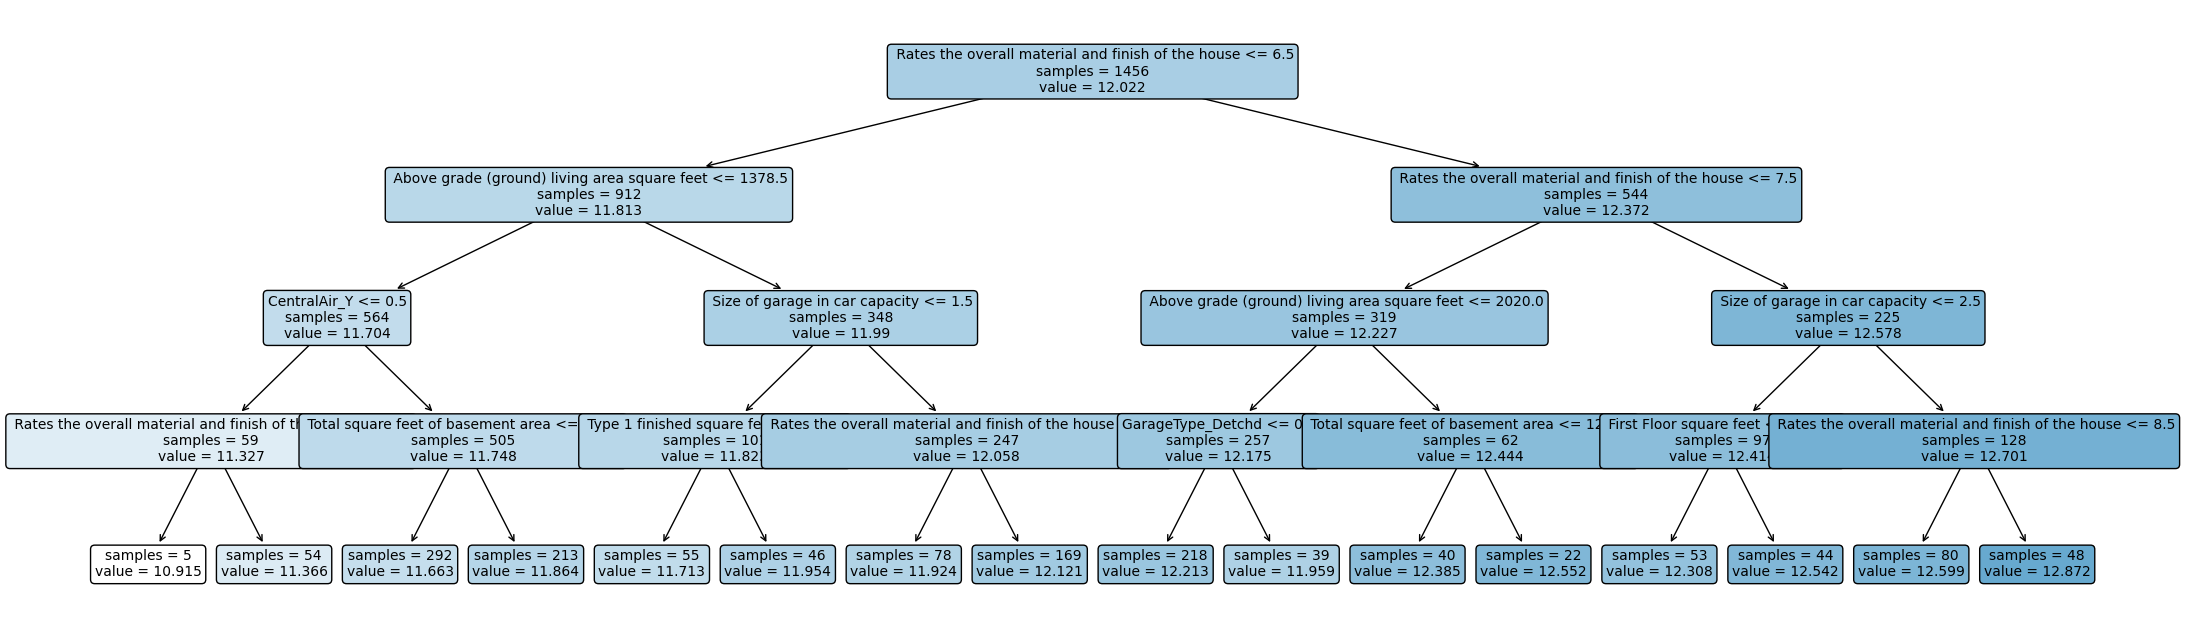

In [9]:
from pyreal.utils.visualize import plot_tree_explanation

plot_tree_explanation(dte)

We can also generate a feature importance explanation from the decision tree explainer that summarizes the overall importance of features across all inputs.

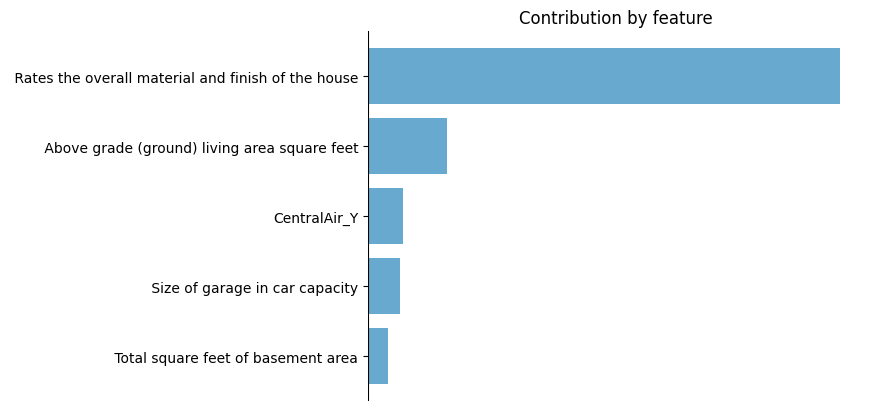

In [10]:
from pyreal import visualize

importances = dte.produce_importances()

visualize.plot_top_contributors(importances, select_by="absolute")